In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tsfm_public.models.tspulse.modeling_tspulse import TSPulseForReconstruction
from tsfm_public.toolkit.ad_helpers import AnomalyScoreMethods
from tsfm_public.toolkit.time_series_anomaly_detection_pipeline import TimeSeriesAnomalyDetectionPipeline

In [3]:
data_path = "https://huggingface.co/datasets/AutonLab/Timeseries-PILE/resolve/main/anomaly_detection/TSB-UAD-Public/IOPS/KPI-4d2af31a-9916-3d9f-8a8e-8a268a48c095.test.out"

In [4]:
def load_data(file_path: str, max_length: int, min_length: int):
    data = []
    extra_args = {}
    if file_path.endswith("gz"):
        extra_args["compression"] = "gzip"
    for chunk in pd.read_csv(file_path, header=None, sep=",", chunksize=max_length, *extra_args):
        if (chunk is None) or (chunk.ndim != 2):
            break
        chunk.columns = ["x", "y"]
        chunk["x"] = chunk.x.interpolate(method="cubic").ffill().bfill()
        chunk["y"] = chunk.y.ffill().bfill()
        if chunk.shape[0] > min_length:
            data.append(chunk)
        elif len(data) > 0:
            data[-1] = pd.concat([data[-1], chunk], axis=0)
    return data


def attach_timestamp_column(
    df: pd.DataFrame, time_col: str = "timestamp", freq: str = "D", start_date: str = "2022-01-01"
):
    n = df.shape[0]
    if time_col not in df:
        df[time_col] = pd.date_range(start_date, freq=freq, periods=n)
    return df

In [5]:
max_length, min_length = 5_000, 2_000

data = load_data(data_path, max_length, min_length)

In [6]:
df = attach_timestamp_column(pd.concat(data), freq='5min')

<Axes: xlabel='timestamp'>

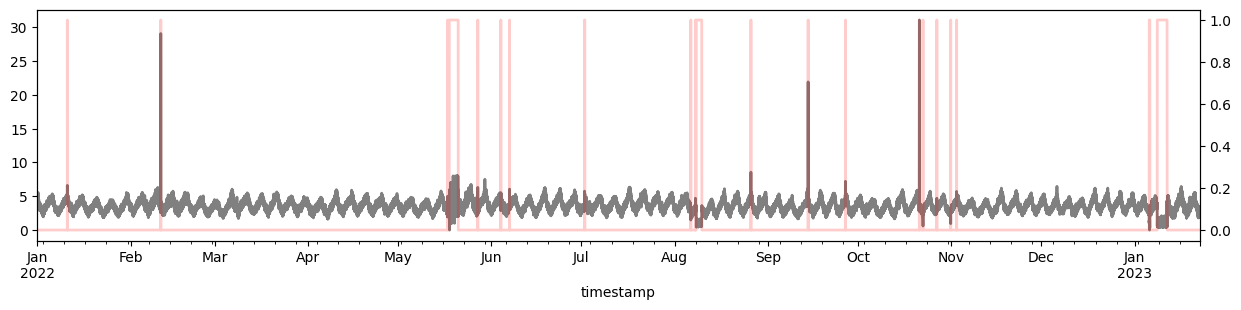

In [7]:
dfx = df.set_index('timestamp')
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax2 = ax.twinx()
dfx.x.plot(ax=ax, color='gray', linewidth=2)
dfx.y.plot(ax=ax2, color='red', alpha=0.2, linewidth=2)

In [8]:
path_to_tspulse_model = "ibm-granite/granite-timeseries-tspulse-r1"
zeroshot_model = TSPulseForReconstruction.from_pretrained(
    path_to_tspulse_model,
    num_input_channels=1,
    revision="main",
    mask_type="user",
)

In [9]:
pipeline = TimeSeriesAnomalyDetectionPipeline(
    zeroshot_model,
    timestamp_column="timestamp",
    target_columns=["x"],
    prediction_mode=[
        AnomalyScoreMethods.TIME_RECONSTRUCTION.value,
        AnomalyScoreMethods.FREQUENCY_RECONSTRUCTION.value,
    ],
    aggregation_length=64,
    aggr_function="max",
    smoothing_length=8,
    least_significant_scale=0.01,
    least_significant_score=0.1,
)

Device set to use mps:0


In [32]:
segment_length = 550
segments = df.shape[0] // segment_length

step = 64
segments = min(segments, 500)

In [33]:
from tqdm import tqdm
state = {}
results = []

for i in tqdm(range(segments)):
    start, end = i * step, (1 + i) * step + segment_length
    result, state = pipeline(df[start:end], batch_size=256, predictive_score_smoothing=False, deployed=True, state=state)
    results.append(result)

100%|███████████████████████████████████████████████████████████████████████████████| 202/202 [03:00<00:00,  1.12it/s]


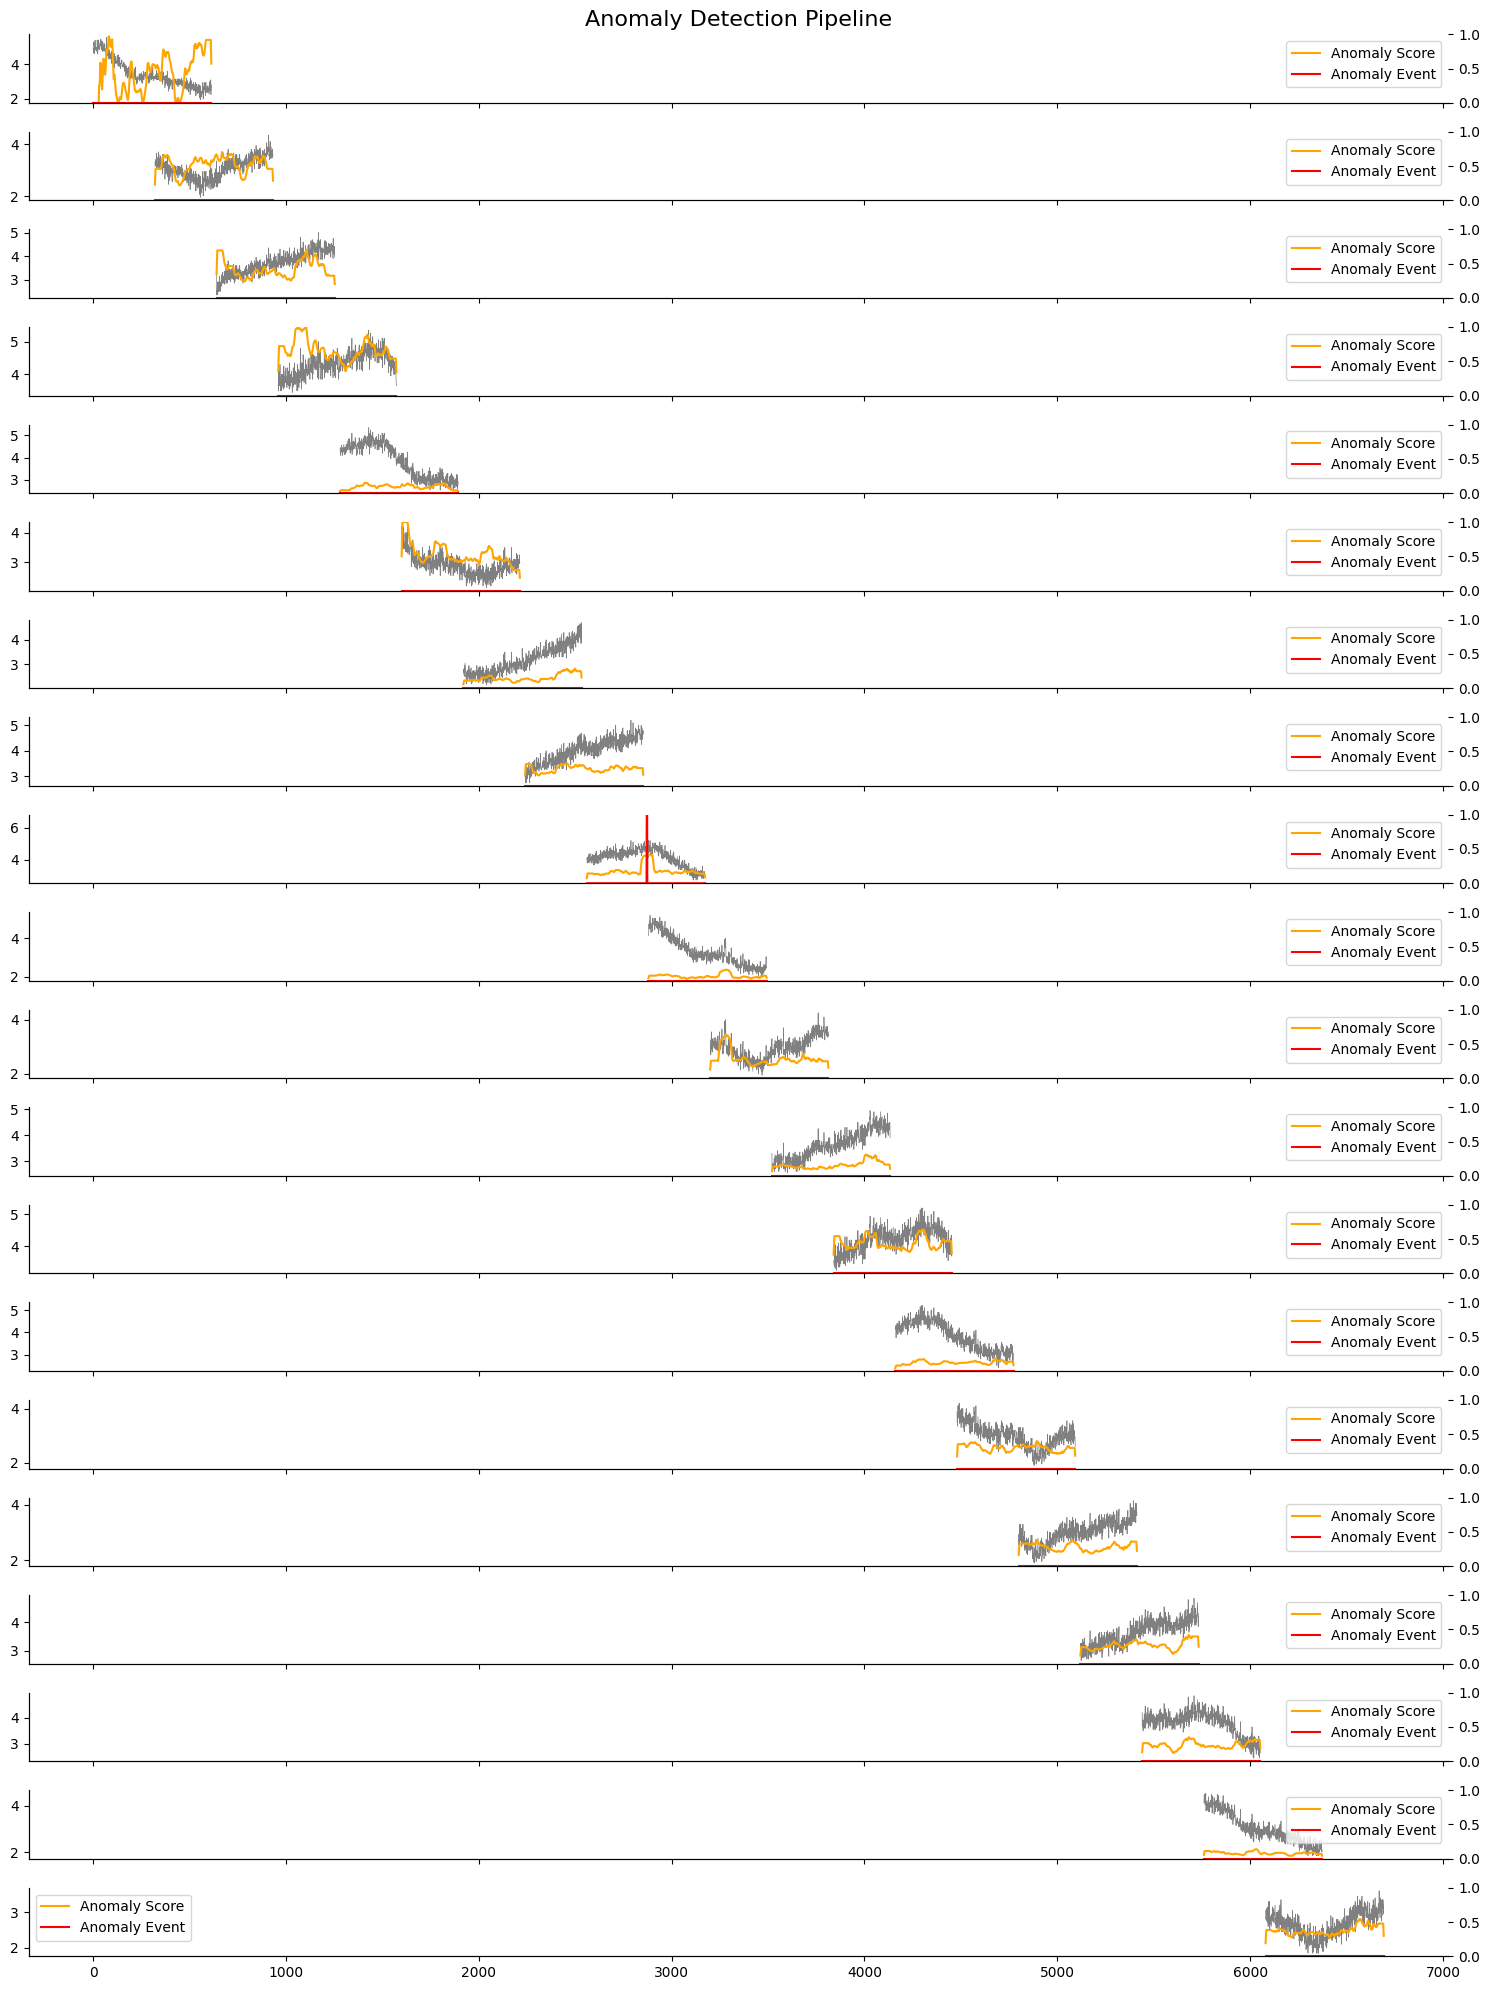

In [37]:
n_plots = 20

n_plots = min(n_plots, len(results))

# n_step = len(results) // n_plots

n_step = 5

fig, axs = plt.subplots(n_plots, 1, sharex='col', figsize=(15, 1 * n_plots))

for i in range(n_plots):
    ax = axs[i] if n_plots > 1 else axs
    segment_id = i * n_step
    result = results[segment_id]
    ax2 = ax.twinx()
    result.x.plot(ax=ax, color="gray", linewidth=0.5)
    result.anomaly_score.plot(ax=ax2, color="orange", label="Anomaly Score")
    result.y.plot(ax=ax2, color="red", label="Anomaly Event")
    ax2.legend()
    ax2.set_ylim(0, 1)
    if i == 0:
        ax.set_title("Anomaly Detection Pipeline", fontsize=16)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
        ax2.spines[s].set_visible(False)

plt.tight_layout()

In [19]:
state

{'time': {'upper': [70.16346740722656], 'lower': [0.028519246727228165]},
 'fft': {'upper': [70.72311401367188], 'lower': [0.04250181093811989]}}